In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt

In [14]:
np.random.seed(42)
torch.manual_seed(42)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(42)

In [3]:
def generate_concentric_circles(num_samples_per_class, inner_radius= 1.0, outer_radius= 2.5, noise=0.2):
    # Generate inner circle data
    angles_inner = 2 * np.pi * np.random.rand(num_samples_per_class)
    radii_inner = inner_radius * np.ones(num_samples_per_class)
    x_inner = radii_inner * np.cos(angles_inner)
    y_inner = radii_inner * np.sin(angles_inner)
    
    # Generate outer circle data
    angles_outer = 2 * np.pi * np.random.rand(num_samples_per_class)
    radii_outer = (outer_radius) * np.ones(num_samples_per_class)
    x_outer = radii_outer * np.cos(angles_outer)
    y_outer = radii_outer * np.sin(angles_outer)
    
    # Add noise
    x_outer += noise * np.random.randn(num_samples_per_class)
    y_outer += noise * np.random.randn(num_samples_per_class)

    # Add noise
    x_inner += noise * np.random.randn(num_samples_per_class)
    y_inner += noise * np.random.randn(num_samples_per_class)
    
    # Combine data
    X = np.vstack((np.column_stack((x_inner, y_inner)), np.column_stack((x_outer, y_outer))))
    y = np.hstack((np.zeros(num_samples_per_class), np.ones(num_samples_per_class)))
    return X, y

In [4]:
# Parameters
num_samples_per_class = 1000  # Number of samples per class

# Generate data
X, y = generate_concentric_circles(num_samples_per_class)

In [5]:
X.shape

(2000, 2)

In [6]:
y.shape

(2000,)

In [7]:
# Custom Dataset Class
class CircleDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.long)

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [8]:
dataset = CircleDataset(X, y)
dataloader = DataLoader(dataset, batch_size=64, shuffle=True)

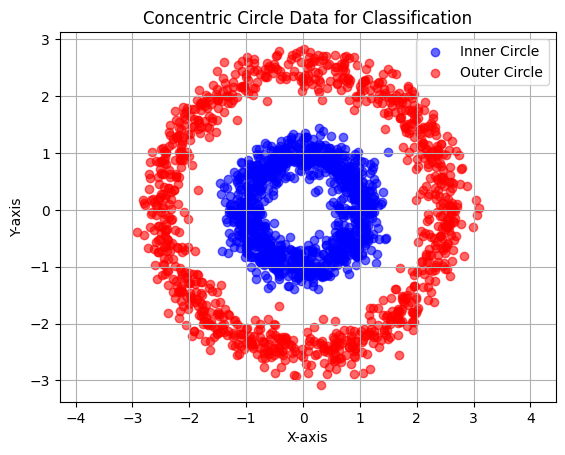

In [9]:
# Plotting
plt.scatter(X[y == 0][:, 0], X[y == 0][:, 1], color='blue', label='Inner Circle', alpha=0.6)
plt.scatter(X[y == 1][:, 0], X[y == 1][:, 1], color='red', label='Outer Circle', alpha=0.6)
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Concentric Circle Data for Classification')
plt.legend()
plt.grid(True)
plt.axis('equal')
plt.show()

In [10]:
# Define MLP model
class MLP(nn.Module):
    def __init__(self):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(2, 128)  # Input layer to hidden layer
        self.fc2 = nn.Linear(128, 64)  # Hidden layer
        self.fc3 = nn.Linear(64, 2)    # Hidden layer to output layer
    
    def forward(self, x):
        x = torch.relu(self.fc1(x))  # Apply ReLU activation
        x = torch.relu(self.fc2(x))  # Apply ReLU activation
        x = self.fc3(x)              # Output layer (no activation here for logits)
        return x

In [13]:
print(model)

MLP(
  (fc1): Linear(in_features=2, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=64, bias=True)
  (fc3): Linear(in_features=64, out_features=2, bias=True)
)


Epoch [1/20], Loss: 0.4054
Epoch [2/20], Loss: 0.0655
Epoch [3/20], Loss: 0.0168
Epoch [4/20], Loss: 0.0082
Epoch [5/20], Loss: 0.0051
Epoch [6/20], Loss: 0.0067
Epoch [7/20], Loss: 0.0020
Epoch [8/20], Loss: 0.0038
Epoch [9/20], Loss: 0.0034
Epoch [10/20], Loss: 0.0009
Epoch [11/20], Loss: 0.0019
Epoch [12/20], Loss: 0.0005
Epoch [13/20], Loss: 0.0011
Epoch [14/20], Loss: 0.0002
Epoch [15/20], Loss: 0.0012
Epoch [16/20], Loss: 0.0005
Epoch [17/20], Loss: 0.0005
Epoch [18/20], Loss: 0.0006
Epoch [19/20], Loss: 0.0012
Epoch [20/20], Loss: 0.0004
Accuracy of the network on the dataset: 100.00%


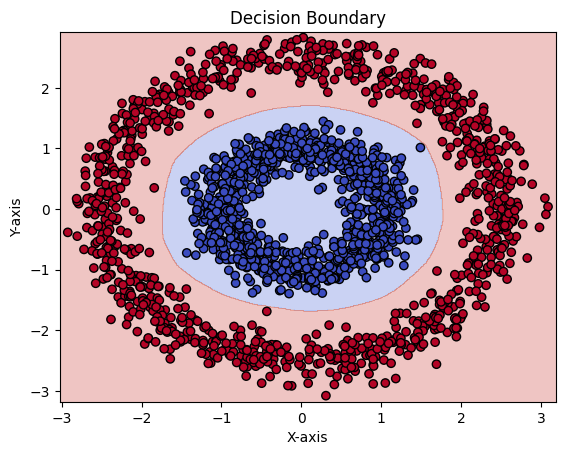

In [11]:
# Initialize the model, loss function, and optimizer
model = MLP()
criterion = nn.CrossEntropyLoss()  # Suitable for classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 20

for epoch in range(num_epochs):
    for batch_X, batch_y in dataloader:
        # Zero the gradients
        optimizer.zero_grad()
        
        # Forward pass
        outputs = model(batch_X)
        loss = criterion(outputs, batch_y)
        
        # Backward pass and optimization
        loss.backward()
        optimizer.step()
    
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}')

# Evaluate the model
with torch.no_grad():
    correct = 0
    total = 0
    for batch_X, batch_y in dataloader:
        outputs = model(batch_X)
        _, predicted = torch.max(outputs.data, 1)
        total += batch_y.size(0)
        correct += (predicted == batch_y).sum().item()

    print(f'Accuracy of the network on the dataset: {100 * correct / total:.2f}%')

# Plot decision boundary
def plot_decision_boundary(model, X, y):
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, 0.01), np.arange(y_min, y_max, 0.01))
    with torch.no_grad():
        Z = model(torch.tensor(np.c_[xx.ravel(), yy.ravel()], dtype=torch.float32))
        _, Z = torch.max(Z, 1)
        Z = Z.numpy().reshape(xx.shape)
    
    plt.contourf(xx, yy, Z, alpha=0.3, cmap='coolwarm')
    plt.scatter(X[:, 0], X[:, 1], c=y, edgecolor='k', cmap='coolwarm')
    plt.xlabel('X-axis')
    plt.ylabel('Y-axis')
    plt.title('Decision Boundary')
    plt.show()

# Plot decision boundary
plot_decision_boundary(model, X, y)